Thành viên nhóm:
* Mai Thị Thảo Ly - 20280064 (trưởng nhóm)
* Lê Thị Mỹ Hằng - 20280028
* Trần Lê Minh - 20280066
* Nguyễn Thị Hồng Thi - 20280088

# Download Data

In [ ]:
#download dataset
!gdown 1v6g9pf18RTnlb_H-WBP9sulKipLRvFwo
!unzip /content/data.zip

In [ ]:
!pip install lightning

# Pytorch Version

## Các bước tiếp cận bài toán

**Image Input:** Nguồn dữ liệu để phát hiện khối u ác tính là hình ảnh nội soi da, là hình ảnh có độ phân giải cao về các tổn thương da hoặc nốt ruồi được chụp bằng máy soi da chuyên dụng. Những hình ảnh này cung cấp thông tin chi tiết về bề mặt da và cấu trúc tổn thương.

**Data Collection:** Hình ảnh soi da được thu thập từ các bệnh nhân có nhiều tình trạng da khác nhau, bao gồm cả tổn thương lành tính và ác tính. Những hình ảnh này được các bác sĩ da liễu dán nhãn để chỉ ra sự hiện diện hay vắng mặt của khối u ác tính.

**Data Preprocessing:** Thay đổi kích thước input từ 300x300 về 224x224. Scale hình ảnh về khoảng (0-1).

**CNN Architecture:** Transfer learning, sử dụng pre-trained model trên tập dữ liệu lớn như ImageNet.
* alexnet
* vgg16_bn
* vgg19_bn
* resnext101_64x4d
* densenet121
* mobilenet_v2

**Training:** CNN đã chọn được train về các hình ảnh nội soi da được dán nhãn. Trong quá trình training, mô hình học cách xác định các đặc điểm và kiểu mẫu trong hình ảnh cho thấy khối u ác tính, điều chỉnh các thông số bên trong của nó thông qua lan truyền ngược để giảm thiểu lỗi phân loại.

**Validation and Hyperparameter Tuning:** Hiệu suất của mô hình được đánh giá bằng cách sử dụng tập dữ liệu validation để ngăn chặn việc overfitting. Các siêu tham số, chẳng hạn như learning rate và batch size, được tinh chỉnh để tối ưu hóa hiệu suất của mô hình.

**Testing:** Sau khi train, mô hình CNN được đánh giá trên một tập dữ liệu thử nghiệm riêng biệt để đánh giá khả năng phân loại chính xác các hình ảnh soi da là lành tính hoặc ác tính.

**Clinical Integration:** Các mô hình CNN được train thành công có thể được tích hợp vào thực hành lâm sàng để hỗ trợ các bác sĩ da liễu trong chẩn đoán khối u ác tính. Các bác sĩ da liễu có thể sử dụng dự đoán của mô hình như một công cụ hỗ trợ quá trình ra quyết định của họ.

Tóm lại, CNN đã chứng minh tiềm năng đáng kể trong việc cải thiện độ chính xác và hiệu quả của việc phát hiện khối u ác tính bằng cách phân tích hình ảnh soi da. Những mô hình học sâu này có thể hỗ trợ các bác sĩ da liễu xác định sớm hơn các tổn thương da có khả năng gây ung thư, mang lại kết quả tốt hơn cho bệnh nhân và có khả năng cứu sống thông qua can thiệp sớm.

In [ ]:
#import thư viện
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torch
import torchvision
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
import os
import glob
from google.colab.patches import cv2_imshow
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch import nn
from lightning.pytorch.callbacks import ModelSummary
from torchvision import transforms

In [ ]:
data_path = "/content/melanoma_cancer_dataset/train/"
list_ = [name for name in os.listdir(data_path)]
list_

['malignant', 'benign']

## Plotting Tensor Data


In [ ]:
def plot_image(num_images_to_show, num_rows, num_cols, data_path):
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4))

  for i, label in enumerate(list_):
      path = os.path.join(data_path, label)
      images = [image for image in os.listdir(path)]
      for j in range(num_images_to_show):
          image_name = images[j]
          image_path = os.path.join(path, image_name)
          img = cv2.imread(image_path)
          axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          axes[i, j].set_title(label)
          axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

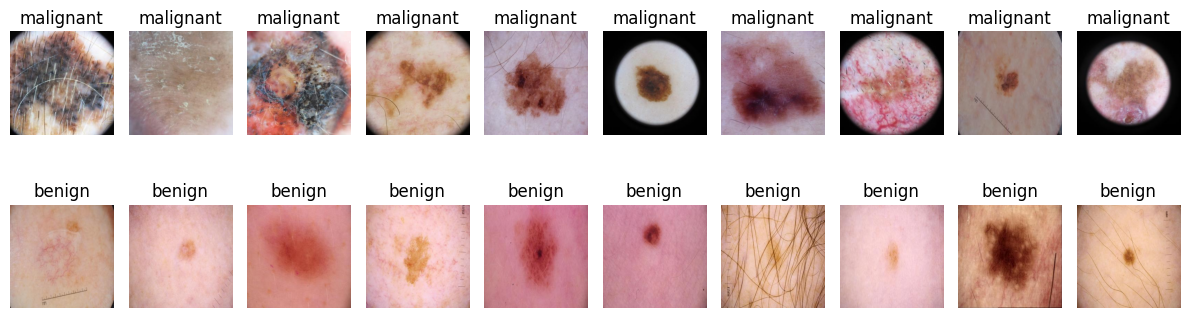

In [ ]:
num_images_to_show = 10
num_rows = len(list_)
num_cols = num_images_to_show
data_path = data_path

plot_image(num_images_to_show, num_rows, num_cols, data_path)

In [ ]:
NAME2NUMBER = {}
for index, label in enumerate(list_):
  NAME2NUMBER[label] = index

def get_path(path):
  paths = []
  for name in list_:
    l = glob.glob(f"{path}{name}/*.jpg")
    for i in l:
      paths.append({"name": name,
                    "path": i,
                    "label": NAME2NUMBER[name]})
  return paths

In [ ]:
data_paths = get_path(data_path)

In [ ]:
class DataSet(torch.utils.data.Dataset):

  def __init__(self, features, new_size = (224,224)):
    super(DataSet, self).__init__()
    self.features = features
    self.resize_transform = torchvision.transforms.Resize(new_size)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    paths = self.features[idx]["path"]
    image = torchvision.io.read_image(paths) / 255.0
    image = self.resize_transform(image)
    label = torch.tensor(self.features[idx]["label"])
    return {"image": image,
            "label": label}

Data = DataSet(data_paths)

In [ ]:
next(iter(Data))["image"].shape

torch.Size([3, 224, 224])

In [ ]:
class DataModule(L.LightningDataModule):
  def __init__(self, batch_size, num_workers, data_path):
    super(DataModule, self).__init__()
    self.data_path = data_path
    self.batch_size = batch_size
    self.num_workers = num_workers

  def setup(self, stage=None):
    data_paths = get_path(self.data_path)
    train_paths, val_paths = train_test_split(data_paths, test_size=0.2, random_state=0)
    train_paths, test_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

    self.train_dataset = DataSet(train_paths)
    self.val_dataset = DataSet(val_paths)
    self.test_dataset = DataSet(test_paths)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)

data_module = DataModule(32, 1, data_path)
data_module.setup()
test_loader = data_module.test_dataloader()
next(iter(test_loader))

{'image': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0

## Training Phase

Các mô hình được xây dựng trên framework Pytorch Lightning, khởi tạo mô hình được cài sẵn từ thư viện torchvision và sử dụng các độ đo như loss, accuracy, precision, recal, f1 để đánh giá mô hình. Ngoài phần xây dựng các tham số cho mô hình (ở phần init) thì các phương thức còn lại đều giống nhau nên ở đây chúng tôi sẽ trình bày về các phương thức giống nhau trong các mô hình, còn điểm khác biệt ở mỗi mô hình sẽ được trình bày trước cell code của mô hình đó.

Phương thức forward(): phương thức này thực hiện quá trình chuyển tiếp của mô hình. Đưa đầu vào 'x' vào mô hình tạo ra một biểu diễn sau cùng, sau đó flatten các biểu diễn để đưa là phần classifier.

Các phương thức train_step, validation_step, test_step là các phương thức thực hiện quá trình lan truyền thuận trong các giai đoạn huấn luyện, đánh giá và kiểm tra. Trong mỗi phương thức, tính toán loss dựa trên đầu ra dự đoán và nhãn thực tế, sau đó log các độ đo loss, accuracy, f1 score, recall, precision.

Phương thức predict_step được sử dụng để dự đoán dữ liệu trên một batch mới. Nó tính xác suất đầu ra sử dụng hàm softmax và sau đó chọn lớp có xác suất cao nhất làm dự đoán.

Phương thức configure_optimizers: định nghĩa tối ưu hoá sử dụng Adam optimizer với learning rate được cài đặt trước đó.




### alexnet

Khởi tạo mô hình với kiến trúc AlexNet. Đóng băng các tham số của mô hình bằng cách cài đặt requires_grad = False để không huấn luyện lại chúng. Sau đó, xác định số lượng đặc trưng đầu ra cuối cùng của mô hình AlexNet và khởi tạo mô hình tuyến tính mới là phần classifier (self.classifier = nn.Sequential(...)). Trong đó, sử dụng các lớp tuyến tính đi kèm với hàm kích hoạt ReLU và Dropout với p = 0.5 để tránh overfitting. Lưu lại giá trị learning rate và khởi tạo giá trị loss bằng hàm CrossEntropyLoss() cùng các độ đo (accuracy, precision, recal, f1) để đánh giá mô hình.



In [ ]:
class alexnet(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2, dropout: float = 0.5):
    super(alexnet, self).__init__()
    backbone = torchvision.models.alexnet(pretrained=True)

    for param in backbone.parameters():
      param.requires_grad = False

    layers = list(backbone.children())[:-1]

    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Sequential(
                                  nn.Dropout(p=dropout),
                                  nn.Linear(256 * 6 * 6, 4096),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(4096, 4096),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(4096, num_target_classes),
                              )
    self.is_train = is_train
    self.learning_rate = learning_rate

    self.loss = torch.nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.classification.BinaryAccuracy()
    self.f1 = torchmetrics.classification.BinaryF1Score()
    self.recall = torchmetrics.classification.BinaryRecall()
    self.precision = torchmetrics.classification.BinaryPrecision()

  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    acc = self.accuracy(predictions, y)
    self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    val_loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    val_acc = self.accuracy(predictions, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    test_loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    test_acc = self.accuracy(predictions, y)
    test_f1 = self.f1(predictions, y)
    test_recall = self.recall(predictions, y)
    test_precision = self.precision(predictions, y)

    self.log_dict({"test_loss": test_loss,
                      "test_acc": test_acc,
                      "test_f1": test_f1,
                      "test_recall": test_recall,
                      "test_precision": test_precision},
                      prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, _ = batch["image"], batch['label']
    probabilities = self(x).softmax(dim=1)
    y_pred = torch.argmax(probabilities, dim=1)
    return y_pred

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = alexnet()
data_module = DataModule(512, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 2.5 M 
1 | classifier        | Sequential       | 54.5 M
2 | loss              | CrossEntropyLoss | 0     
3 | accuracy          | BinaryAccuracy   | 0     
4 | f1                | BinaryF1Score    | 0     
5 | recall            | BinaryRecall     | 0     
6 | precision         | BinaryPrecision  | 0     
-------------------------------------------------------
54.5 M    Trainable params
2.5 M     Non-trainable params
57.0 M    Total params
228.048   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 2.5 M 
1 | classifier  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 14: 'val_acc' reached 0.80339 (best 0.80339), saving model to '/content/checkpoint/epoch=0-step=14-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 14: 'val_acc' reached 0.80339 (best 0.80339), saving model to '/content/checkpoint/epoch=0-step=14-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 28: 'val_acc' reached 0.87082 (best 0.87082), saving model to '/content/checkpoint/epoch=1-step=28.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 28: 'val_acc' reached 0.87082 (best 0.87082), saving model to '/content/checkpoint/epoch=1-step=28.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 42: 'val_acc' reached 0.89250 (best 0.89250), saving model to '/content/checkpoint/epoch=2-step=42.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 42: 'val_acc' reached 0.89250 (best 0.89250), saving model to '/content/checkpoint/epoch=2-step=42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 56: 'val_acc' reached 0.89769 (best 0.89769), saving model to '/content/checkpoint/epoch=3-step=56.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 56: 'val_acc' reached 0.89769 (best 0.89769), saving model to '/content/checkpoint/epoch=3-step=56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 70: 'val_acc' reached 0.90853 (best 0.90853), saving model to '/content/checkpoint/epoch=4-step=70.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 70: 'val_acc' reached 0.90853 (best 0.90853), saving model to '/content/checkpoint/epoch=4-step=70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 84: 'val_acc' reached 0.90948 (best 0.90948), saving model to '/content/checkpoint/epoch=5-step=84.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 84: 'val_acc' reached 0.90948 (best 0.90948), saving model to '/content/checkpoint/epoch=5-step=84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 98: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/epoch=6-step=98.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 98: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/epoch=6-step=98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 112: 'val_acc' reached 0.91749 (best 0.91749), saving model to '/content/checkpoint/epoch=7-step=112.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 112: 'val_acc' reached 0.91749 (best 0.91749), saving model to '/content/checkpoint/epoch=7-step=112.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 126: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 126: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 140: 'val_acc' reached 0.91891 (best 0.91891), saving model to '/content/checkpoint/epoch=9-step=140.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 140: 'val_acc' reached 0.91891 (best 0.91891), saving model to '/content/checkpoint/epoch=9-step=140.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 154: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 154: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 168: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 168: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 182: 'val_acc' reached 0.92362 (best 0.92362), saving model to '/content/checkpoint/epoch=12-step=182.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 182: 'val_acc' reached 0.92362 (best 0.92362), saving model to '/content/checkpoint/epoch=12-step=182.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 196: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 196: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 210: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 210: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 224: 'val_acc' reached 0.93069 (best 0.93069), saving model to '/content/checkpoint/epoch=15-step=224.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 224: 'val_acc' reached 0.93069 (best 0.93069), saving model to '/content/checkpoint/epoch=15-step=224.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 238: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 238: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 252: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 252: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 266: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 266: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 280: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 280: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 294: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 294: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.931644082069397     │
│          test_f1          │    0.9321092963218689     │
│         test_loss         │    0.22181512415409088    │
│      test_precision       │    0.9184646606445312     │
│        test_recall        │    0.9463866949081421     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22181512415409088,
  'test_acc': 0.931644082069397,
  'test_f1': 0.9321092963218689,
  'test_recall': 0.9463866949081421,
  'test_precision': 0.9184646606445312}]

### vgg16_bn

Khởi tạo mô hình với kiến trúc vgg16_bn. Đóng băng các tham số của mô hình bằng cách cài đặt requires_grad = False để không huấn luyện lại chúng. Xác định số lượng đặc trưng đầu ra của lớp cuối cùng trong mô hình VGG16 dựa trên giả định rằng kích thước của feature map cuối cùng là 7x7 và có 512 kênh. Sau đó, khởi tạo mô hình tuyến tính mới là phần classifier với với số lượng đầu ra là num_target_classes.

In [ ]:
class vgg16_bn(L.LightningModule):
    def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
      super(vgg16_bn, self).__init__()

      backbone = torchvision.models.vgg16_bn(pretrained=True)
      for param in backbone.parameters():
                param.requires_grad = False

      #num_filters = backbone.classifier[-1].out_features
      num_filters = 512 * 7 * 7  # Assuming 7x7 is the size of the last feature map

      layers = list(backbone.children())[:-1]

      self.feature_extractor = torch.nn.Sequential(*layers)
      self.classifier = nn.Linear(num_filters, num_target_classes)
      self.is_train = is_train
      self.learning_rate = learning_rate

      self.loss = torch.nn.CrossEntropyLoss()
      self.accuracy = torchmetrics.classification.BinaryAccuracy()
      self.f1 = torchmetrics.classification.BinaryF1Score()
      self.recall = torchmetrics.classification.BinaryRecall()
      self.precision = torchmetrics.classification.BinaryPrecision()


    def forward(self, x):
      x = self.feature_extractor(x)
      x = x.view(x.size(0), -1)  # Flatten the tensor for the linear layer

      # Always apply the linear layer during forward pass
      x = self.classifier(x)

      return x

    def training_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      acc = self.accuracy(predictions, y)
      self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
      return loss

    def validation_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      val_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      val_acc = self.accuracy(predictions, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      test_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      test_acc = self.accuracy(predictions, y)
      test_f1 = self.f1(predictions, y)
      test_recall = self.recall(predictions, y)
      test_precision = self.precision(predictions, y)

      self.log_dict({"test_loss": test_loss,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "test_recall": test_recall,
                        "test_precision": test_precision},
                        prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx):
      x, _ = batch["image"], batch['label']
      probabilities = self(x).softmax(dim=1)
      y_pred = torch.argmax(probabilities, dim=1)
      return y_pred

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = vgg16_bn()
data_module = DataModule(32, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 14.7 M
1 | classifier        | Linear           | 50.2 K
2 | loss              | CrossEntropyLoss | 0     
3 | accuracy          | BinaryAccuracy   | 0     
4 | f1                | BinaryF1Score    | 0     
5 | recall            | BinaryRecall     | 0     
6 | precision         | BinaryPrecision  | 0     
-------------------------------------------------------
50.2 K    Trainable params
14.7 M    Non-trainable params
14.8 M    Total params
59.093    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 14.7 M
1 | classifier  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 213: 'val_acc' reached 0.91042 (best 0.91042), saving model to '/content/checkpoint/epoch=0-step=213.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 213: 'val_acc' reached 0.91042 (best 0.91042), saving model to '/content/checkpoint/epoch=0-step=213.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 426: 'val_acc' reached 0.92174 (best 0.92174), saving model to '/content/checkpoint/epoch=1-step=426.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 426: 'val_acc' reached 0.92174 (best 0.92174), saving model to '/content/checkpoint/epoch=1-step=426.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 639: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 639: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 852: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 852: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1065: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1065: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1278: 'val_acc' reached 0.92551 (best 0.92551), saving model to '/content/checkpoint/epoch=5-step=1278.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1278: 'val_acc' reached 0.92551 (best 0.92551), saving model to '/content/checkpoint/epoch=5-step=1278.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 1491: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 1491: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1704: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1704: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1917: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1917: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2130: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 2130: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 2343: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 2343: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9263405799865723     │
│          test_f1          │     0.926206111907959     │
│         test_loss         │    0.3039229214191437     │
│      test_precision       │    0.9263739585876465     │
│        test_recall        │    0.9295340180397034     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3039229214191437,
  'test_acc': 0.9263405799865723,
  'test_f1': 0.926206111907959,
  'test_recall': 0.9295340180397034,
  'test_precision': 0.9263739585876465}]

### vgg19_bn
Tương tự như vgg16_bn, vgg19_bn cũng thực hiện các bước đóng băng tham số, cài đặt phần classifer và lưu lại các metric.

In [ ]:
class vgg19_bn(L.LightningModule):
    def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
      super(vgg19_bn, self).__init__()

      backbone = torchvision.models.vgg19_bn(pretrained=True)
      for param in backbone.parameters():
                param.requires_grad = False

      #num_filters = backbone.classifier[-1].out_features
      num_filters = 512 * 7 * 7  # Assuming 7x7 is the size of the last feature map

      layers = list(backbone.children())[:-1]

      self.feature_extractor = torch.nn.Sequential(*layers)
      self.classifier = nn.Linear(num_filters, num_target_classes)
      self.is_train = is_train
      self.learning_rate = learning_rate

      self.loss = torch.nn.CrossEntropyLoss()
      self.accuracy = torchmetrics.classification.BinaryAccuracy()
      self.f1 = torchmetrics.classification.BinaryF1Score()
      self.recall = torchmetrics.classification.BinaryRecall()
      self.precision = torchmetrics.classification.BinaryPrecision()


    def forward(self, x):
      x = self.feature_extractor(x)
      x = x.view(x.size(0), -1)  # Flatten the tensor for the linear layer

      # Always apply the linear layer during forward pass
      x = self.classifier(x)

      return x

    def training_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      acc = self.accuracy(predictions, y)
      self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
      return loss

    def validation_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      val_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      val_acc = self.accuracy(predictions, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      test_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      test_acc = self.accuracy(predictions, y)
      test_f1 = self.f1(predictions, y)
      test_recall = self.recall(predictions, y)
      test_precision = self.precision(predictions, y)

      self.log_dict({"test_loss": test_loss,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "test_recall": test_recall,
                        "test_precision": test_precision},
                        prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx):
      x, _ = batch["image"], batch['label']
      probabilities = self(x).softmax(dim=1)
      y_pred = torch.argmax(probabilities, dim=1)
      return y_pred

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = vgg19_bn()
data_module = DataModule(512, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 20.0 M
1 | classifier        | Linear           | 50.2 K
2 | loss              | CrossEntropyLoss | 0     
3 | accuracy          | BinaryAccuracy   | 0     
4 | f1                | BinaryF1Score    | 0     
5 | recall            | BinaryRecall     | 0     
6 | precision         | BinaryPrecision  | 0     
-------------------------------------------------------
50.2 K    Trainable params
20.0 M    Non-trainable params
20.1 M    Total params
80.342    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 20.0 M
1 | classifier  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 14: 'val_acc' reached 0.80622 (best 0.80622), saving model to '/content/checkpoint/epoch=0-step=14.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 14: 'val_acc' reached 0.80622 (best 0.80622), saving model to '/content/checkpoint/epoch=0-step=14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 28: 'val_acc' reached 0.85761 (best 0.85761), saving model to '/content/checkpoint/epoch=1-step=28.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 28: 'val_acc' reached 0.85761 (best 0.85761), saving model to '/content/checkpoint/epoch=1-step=28.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 42: 'val_acc' reached 0.89250 (best 0.89250), saving model to '/content/checkpoint/epoch=2-step=42.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 42: 'val_acc' reached 0.89250 (best 0.89250), saving model to '/content/checkpoint/epoch=2-step=42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 56: 'val_acc' reached 0.90806 (best 0.90806), saving model to '/content/checkpoint/epoch=3-step=56.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 56: 'val_acc' reached 0.90806 (best 0.90806), saving model to '/content/checkpoint/epoch=3-step=56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 70: 'val_acc' reached 0.91466 (best 0.91466), saving model to '/content/checkpoint/epoch=4-step=70.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 70: 'val_acc' reached 0.91466 (best 0.91466), saving model to '/content/checkpoint/epoch=4-step=70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 84: 'val_acc' reached 0.91561 (best 0.91561), saving model to '/content/checkpoint/epoch=5-step=84.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 84: 'val_acc' reached 0.91561 (best 0.91561), saving model to '/content/checkpoint/epoch=5-step=84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 98: 'val_acc' reached 0.91843 (best 0.91843), saving model to '/content/checkpoint/epoch=6-step=98.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 98: 'val_acc' reached 0.91843 (best 0.91843), saving model to '/content/checkpoint/epoch=6-step=98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 112: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 112: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 126: 'val_acc' reached 0.92079 (best 0.92079), saving model to '/content/checkpoint/epoch=8-step=126.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 126: 'val_acc' reached 0.92079 (best 0.92079), saving model to '/content/checkpoint/epoch=8-step=126.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 140: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 140: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 154: 'val_acc' reached 0.92598 (best 0.92598), saving model to '/content/checkpoint/epoch=10-step=154.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 154: 'val_acc' reached 0.92598 (best 0.92598), saving model to '/content/checkpoint/epoch=10-step=154.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 168: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 168: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 182: 'val_acc' reached 0.92692 (best 0.92692), saving model to '/content/checkpoint/epoch=12-step=182.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 182: 'val_acc' reached 0.92692 (best 0.92692), saving model to '/content/checkpoint/epoch=12-step=182.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 196: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 196: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 210: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 210: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 224: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 224: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 238: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 238: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 252: 'val_acc' reached 0.92975 (best 0.92975), saving model to '/content/checkpoint/epoch=17-step=252.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 252: 'val_acc' reached 0.92975 (best 0.92975), saving model to '/content/checkpoint/epoch=17-step=252.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 266: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 266: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 280: 'val_acc' reached 0.93022 (best 0.93022), saving model to '/content/checkpoint/epoch=19-step=280.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 280: 'val_acc' reached 0.93022 (best 0.93022), saving model to '/content/checkpoint/epoch=19-step=280.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 294: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 294: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 308: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 308: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 322: 'val_acc' reached 0.93305 (best 0.93305), saving model to '/content/checkpoint/epoch=22-step=322.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 322: 'val_acc' reached 0.93305 (best 0.93305), saving model to '/content/checkpoint/epoch=22-step=322.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 336: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 336: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 24, global step 350: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 350: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 25, global step 364: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 364: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 378: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 378: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 27, global step 392: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 392: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9275191426277161     │
│          test_f1          │    0.9279593825340271     │
│         test_loss         │    0.19177645444869995    │
│      test_precision       │    0.9166999459266663     │
│        test_recall        │    0.9400001168251038     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19177645444869995,
  'test_acc': 0.9275191426277161,
  'test_f1': 0.9279593825340271,
  'test_recall': 0.9400001168251038,
  'test_precision': 0.9166999459266663}]

### resnext101_64x4d
Xây dựng model resnet101 tương tự các model trên. ResNet-101 64 4d là một kiến trúc mạng nơ-ron tích chập (CNN). Đây là một biến thể của kiến trúc ResNet sử dụng phép tích chập 4D thay cho phép tích chập 2D được sử dụng trong ResNet gốc. Điều này cho phép ResNet-101 64x4d học được các đặc trưng phức tạp hơn từ hình ảnh đầu vào. Kiến trúc ResNet-101 64x4d bao gồm 101 tầng, được chia thành 34 khối residual.


In [ ]:
class resnext101_64x4d(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
    super(resnext101_64x4d, self).__init__()
    backbone = torchvision.models.resnext101_64x4d(weights="DEFAULT")

    for param in backbone.parameters():
      param.requires_grad = False

    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]

    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Linear(num_filters, num_target_classes)
    self.is_train = is_train
    self.learning_rate = learning_rate
    self.loss = torch.nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.classification.BinaryAccuracy()
    self.f1 = torchmetrics.classification.BinaryF1Score()
    self.recall = torchmetrics.classification.BinaryRecall()
    self.precision = torchmetrics.classification.BinaryPrecision()

  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    acc = self.accuracy(predictions, y)
    self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    val_loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    val_acc = self.accuracy(predictions, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    test_loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    test_acc = self.accuracy(predictions, y)
    test_f1 = self.f1(predictions, y)
    test_recall = self.recall(predictions, y)
    test_precision = self.precision(predictions, y)

    self.log_dict({"test_loss": test_loss,
                      "test_acc": test_acc,
                      "test_f1": test_f1,
                      "test_recall": test_recall,
                      "test_precision": test_precision},
                      prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, _ = batch["image"], batch['label']
    probabilities = self(x).softmax(dim=1)
    y_pred = torch.argmax(probabilities, dim=1)
    return y_pred

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = resnext101_64x4d()
data_module = DataModule(256, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)

Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:02<00:00, 150MB/s]
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:

In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 81.4 M
1 | classifier        | Linear           | 4.1 K 
2 | loss              | CrossEntropyLoss | 0     
3 | accuracy          | BinaryAccuracy   | 0     
4 | f1                | BinaryF1Score    | 0     
5 | recall            | BinaryRecall     | 0     
6 | precision         | BinaryPrecision  | 0     
-------------------------------------------------------
4.1 K     Trainable params
81.4 M    Non-trainable params
81.4 M    Total params
325.641   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 81.4 M
1 | classifier  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 27: 'val_acc' reached 0.87459 (best 0.87459), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 27: 'val_acc' reached 0.87459 (best 0.87459), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 54: 'val_acc' reached 0.88732 (best 0.88732), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 54: 'val_acc' reached 0.88732 (best 0.88732), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 81: 'val_acc' reached 0.89910 (best 0.89910), saving model to '/content/checkpoint/epoch=2-step=81.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 81: 'val_acc' reached 0.89910 (best 0.89910), saving model to '/content/checkpoint/epoch=2-step=81.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 108: 'val_acc' reached 0.90335 (best 0.90335), saving model to '/content/checkpoint/epoch=3-step=108.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 108: 'val_acc' reached 0.90335 (best 0.90335), saving model to '/content/checkpoint/epoch=3-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 135: 'val_acc' reached 0.90665 (best 0.90665), saving model to '/content/checkpoint/epoch=4-step=135.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 135: 'val_acc' reached 0.90665 (best 0.90665), saving model to '/content/checkpoint/epoch=4-step=135.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 162: 'val_acc' reached 0.90995 (best 0.90995), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 162: 'val_acc' reached 0.90995 (best 0.90995), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 189: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 189: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 216: 'val_acc' reached 0.91325 (best 0.91325), saving model to '/content/checkpoint/epoch=7-step=216.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 216: 'val_acc' reached 0.91325 (best 0.91325), saving model to '/content/checkpoint/epoch=7-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 243: 'val_acc' reached 0.91702 (best 0.91702), saving model to '/content/checkpoint/epoch=8-step=243.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 243: 'val_acc' reached 0.91702 (best 0.91702), saving model to '/content/checkpoint/epoch=8-step=243.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 270: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 270: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 297: 'val_acc' reached 0.91891 (best 0.91891), saving model to '/content/checkpoint/epoch=10-step=297.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 297: 'val_acc' reached 0.91891 (best 0.91891), saving model to '/content/checkpoint/epoch=10-step=297.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 324: 'val_acc' reached 0.91938 (best 0.91938), saving model to '/content/checkpoint/epoch=11-step=324.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 324: 'val_acc' reached 0.91938 (best 0.91938), saving model to '/content/checkpoint/epoch=11-step=324.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 351: 'val_acc' reached 0.91985 (best 0.91985), saving model to '/content/checkpoint/epoch=12-step=351.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 351: 'val_acc' reached 0.91985 (best 0.91985), saving model to '/content/checkpoint/epoch=12-step=351.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 378: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 378: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 405: 'val_acc' reached 0.92174 (best 0.92174), saving model to '/content/checkpoint/epoch=14-step=405.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 405: 'val_acc' reached 0.92174 (best 0.92174), saving model to '/content/checkpoint/epoch=14-step=405.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 432: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 432: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 459: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/epoch=16-step=459.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 459: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/epoch=16-step=459.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 486: 'val_acc' reached 0.92456 (best 0.92456), saving model to '/content/checkpoint/epoch=17-step=486.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 486: 'val_acc' reached 0.92456 (best 0.92456), saving model to '/content/checkpoint/epoch=17-step=486.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 513: 'val_acc' reached 0.92786 (best 0.92786), saving model to '/content/checkpoint/epoch=18-step=513.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 513: 'val_acc' reached 0.92786 (best 0.92786), saving model to '/content/checkpoint/epoch=18-step=513.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 540: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 540: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 567: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 567: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 594: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 594: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 621: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 621: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 648: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 648: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9292869567871094     │
│          test_f1          │    0.9301661252975464     │
│         test_loss         │    0.19531665742397308    │
│      test_precision       │    0.9213492274284363     │
│        test_recall        │    0.9396917223930359     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19531665742397308,
  'test_acc': 0.9292869567871094,
  'test_f1': 0.9301661252975464,
  'test_recall': 0.9396917223930359,
  'test_precision': 0.9213492274284363}]

### densenet121

Khởi tạo mô hình với kiến trúc densenet121. Tương tự các mô hình trước, đóng băng các tham số của mô hình bằng cách cài đặt requires_grad = False. Sau đó, xác định số lượng đặc trưng đầu ra cuối cùng của mô hình densenet121 và khởi tạo mô hình tuyến tính mới là phần classifier (self.classifier = nn.Sequential(...)). Trong đó, sử dụng 2 lớp tuyến tính, lớp thứ nhất đi kèm với hàm kích hoạt ReLU và Dropout với p = 0.5 để tránh overfitting, lớp thứ hai với đầu ra là num_target_classes = 2 kết hợp với hàm kích hoạt sigmoid cho bài toán phân lớp nhị phân.


In [ ]:
class densenet(L.LightningModule):
    def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
      super(densenet, self).__init__()

      self.backbone = torchvision.models.densenet121(pretrained=True)
      for param in self.backbone.parameters():
                param.requires_grad = False

      num_ftrs = self.backbone.classifier.out_features

      self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_target_classes),
            nn.Sigmoid()
        )

      self.is_train = is_train
      self.learning_rate = learning_rate

      self.loss = torch.nn.CrossEntropyLoss()
      self.accuracy = torchmetrics.classification.BinaryAccuracy()
      self.f1 = torchmetrics.classification.BinaryF1Score()
      self.recall = torchmetrics.classification.BinaryRecall()
      self.precision = torchmetrics.classification.BinaryPrecision()

    def forward(self, x):
      x = self.backbone(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x

    def training_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      acc = self.accuracy(predictions, y)
      self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
      return loss

    def validation_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      val_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      val_acc = self.accuracy(predictions, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      test_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      test_acc = self.accuracy(predictions, y)
      test_f1 = self.f1(predictions, y)
      test_recall = self.recall(predictions, y)
      test_precision = self.precision(predictions, y)

      self.log_dict({"test_loss": test_loss,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "test_recall": test_recall,
                        "test_precision": test_precision},
                        prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx):
      x, _ = batch["image"], batch['label']
      probabilities = self(x).softmax(dim=1)
      y_pred = torch.argmax(probabilities, dim=1)
      return y_pred

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = densenet()
data_module = DataModule(128, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = densenet()
data_module = DataModule(256, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 27: 'val_acc' reached 0.89298 (best 0.89298), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 27: 'val_acc' reached 0.89298 (best 0.89298), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 54: 'val_acc' reached 0.91089 (best 0.91089), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 54: 'val_acc' reached 0.91089 (best 0.91089), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 81: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 81: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias p

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 108: 'val_acc' reached 0.91419 (best 0.91419), saving model to '/content/checkpoint/epoch=3-step=108.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 108: 'val_acc' reached 0.91419 (best 0.91419), saving model to '/content/checkpoint/epoch=3-step=108.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 135: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 135: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 162: 'val_acc' reached 0.92126 (best 0.92126), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 162: 'val_acc' reached 0.92126 (best 0.92126), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 189: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 189: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 216: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 216: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 243: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 243: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 270: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 270: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 297: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 297: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9263405799865723     │
│          test_f1          │    0.9263384342193604     │
│         test_loss         │    0.3836638331413269     │
│      test_precision       │    0.9264854192733765     │
│        test_recall        │    0.9271486401557922     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3836638331413269,
  'test_acc': 0.9263405799865723,
  'test_f1': 0.9263384342193604,
  'test_recall': 0.9271486401557922,
  'test_precision': 0.9264854192733765}]

### mobilenet_v2

Khởi tạo mô hình với kiến trúc mobilenet_v2. Tương tự các mô hình trước, đóng băng các tham số của mô hình bằng cách cài đặt requires_grad = False. Sau đó, xác định số lượng đặc trưng đầu ra cuối cùng của mô hình mobilenet_v2 và khởi tạo mô hình tuyến tính mới là phần classifier (self.classifier = nn.Sequential(...)). Trong đó, sử dụng 2 lớp tuyến tính, lớp thứ nhất đi kèm với hàm kích hoạt ReLU và Dropout với p = 0.3 để tránh overfitting, lớp thứ hai với đầu ra là num_target_classes = 2 kết hợp với hàm kích hoạt sigmoid cho bài toán phân lớp nhị phân.


In [ ]:
class mobilenetv2(L.LightningModule):
    def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
      super(mobilenetv2, self).__init__()

      self.backbone = torchvision.models.mobilenet_v2(pretrained=True)
      for param in self.backbone.parameters():
                param.requires_grad = False

      num_ftrs = self.backbone.classifier[-1].out_features

      self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_target_classes),
            nn.Sigmoid()
        )

      self.is_train = is_train
      self.learning_rate = learning_rate

      self.loss = torch.nn.CrossEntropyLoss()
      self.accuracy = torchmetrics.classification.BinaryAccuracy()
      self.f1 = torchmetrics.classification.BinaryF1Score()
      self.recall = torchmetrics.classification.BinaryRecall()
      self.precision = torchmetrics.classification.BinaryPrecision()

    def forward(self, x):
      x = self.backbone(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x

    def training_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      acc = self.accuracy(predictions, y)
      self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
      return loss

    def validation_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      val_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      val_acc = self.accuracy(predictions, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      test_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      test_acc = self.accuracy(predictions, y)
      test_f1 = self.f1(predictions, y)
      test_recall = self.recall(predictions, y)
      test_precision = self.precision(predictions, y)

      self.log_dict({"test_loss": test_loss,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "test_recall": test_recall,
                        "test_precision": test_precision},
                        prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx):
      x, _ = batch["image"], batch['label']
      probabilities = self(x).softmax(dim=1)
      y_pred = torch.argmax(probabilities, dim=1)
      return y_pred

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = mobilenetv2()
data_module = DataModule(256, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  w

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 27: 'val_acc' reached 0.87977 (best 0.87977), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 27: 'val_acc' reached 0.87977 (best 0.87977), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 54: 'val_acc' reached 0.90995 (best 0.90995), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 54: 'val_acc' reached 0.90995 (best 0.90995), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 81: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 81: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias p

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 108: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 108: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 135: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 135: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 162: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 162: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 189: 'val_acc' reached 0.91183 (best 0.91183), saving model to '/content/checkpoint/epoch=6-step=189.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 189: 'val_acc' reached 0.91183 (best 0.91183), saving model to '/content/checkpoint/epoch=6-step=189.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 216: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 216: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 243: 'val_acc' reached 0.91608 (best 0.91608), saving model to '/content/checkpoint/epoch=8-step=243.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 243: 'val_acc' reached 0.91608 (best 0.91608), saving model to '/content/checkpoint/epoch=8-step=243.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 270: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 270: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 297: 'val_acc' reached 0.91702 (best 0.91702), saving model to '/content/checkpoint/epoch=10-step=297.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 297: 'val_acc' reached 0.91702 (best 0.91702), saving model to '/content/checkpoint/epoch=10-step=297.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 324: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 324: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 351: 'val_acc' reached 0.91749 (best 0.91749), saving model to '/content/checkpoint/epoch=12-step=351.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 351: 'val_acc' reached 0.91749 (best 0.91749), saving model to '/content/checkpoint/epoch=12-step=351.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 378: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 378: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 405: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/epoch=14-step=405.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 405: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/epoch=14-step=405.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 432: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 432: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 459: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 459: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 486: 'val_acc' reached 0.92315 (best 0.92315), saving model to '/content/checkpoint/epoch=17-step=486.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 486: 'val_acc' reached 0.92315 (best 0.92315), saving model to '/content/checkpoint/epoch=17-step=486.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 513: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 513: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 540: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 540: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 567: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 567: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 594: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 594: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 621: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 621: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also a

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9233942031860352     │
│          test_f1          │    0.9236893057823181     │
│         test_loss         │    0.38610756397247314    │
│      test_precision       │    0.9208922386169434     │
│        test_recall        │    0.9271844029426575     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.38610756397247314,
  'test_acc': 0.9233942031860352,
  'test_f1': 0.9236893057823181,
  'test_recall': 0.9271844029426575,
  'test_precision': 0.9208922386169434}]

### Kết luận

Những model đã học được dùng để giải quyết bài toán phân biệt được khối u ác tính với một ảnh đầu vào:  


- **$VGG16(BN)$**  
  
Info|Params|
-|:-:|
feature_extractor|14.7 M |
classifier|50.2 K|


- **$VGG19(BN)$**  

Info|Params|
-|:-:|
feature_extractor|20.0 M |
classifier|50.2 K|


- **$RESNET101(64x4D)$**  


Info|Params|
-|:-:|
feature_extractor|81.4 M |
classifier|4.1 K|


- **$ALEXNET$**  

Info|Params|
-|:-:|
feature_extractor|2.5 M |
classifier|54.5 M|

- **$DENSENET121$**

Info|Params|
-|:-:|
backbone r|8.0 M |
classifier|256 K |

- **$MOBILENET(V2)$**

Info|Params|
-|:-:|
backbone |3.5 M|
classifier|513 K|


Như vậy, ta có bảng kết luận $accuracy$ ,$f1score$ ,$precision$ ,$recall$ như sau:

Model|ACC|F1_score|Precision|Recall|
-|:-:|:-:|:-:|:-:|
VGG16 (BN)|0.9263|0.9262|0.9263|0.929|
VGG19 (BN)|0.9275|0.9279|0.9166|0.940|
RESNET101(64x4D)|0.9292|0.9301|0.9213|0.9396|
ALEXNET|0.9316|0.932|0.9463|0.918|
DENSENET121|0.9263|0.9263|0.9264|0.9271|
MOBILENET(V2)|0.9233|0.9236|0.9208|0.9271|

Với số lượng data tương đối:   
`len(data_paths) = 10605`  
`len(list(filter(lambda x: x['label'] == 0, data_paths))) = 5105`  
`list(filter(lambda x: x['label'] == 1, data_paths)) = 5500`  

Đa phần các mô hình với số lượng `params` tương đối khác nhau cũng có thể chạy với kết quả không khác nhau nhiều, tuy nhiên để tránh overfitting và tối ưu về không gian lẫn thời gian thì `ALEXNET` là hiệu quả nhất

# **Keras Version**


Dưới đây là phiên bản mã nguồn sử dụng Keras. Keras được chọn vì tính năng dễ sử dụng và khả năng điều chỉnh các lớp sâu trong các mô hình đã được huấn luyện trước (pretrained models) một cách linh hoạt hơn so với PyTorch. Ngoài ra, một số mô hình đã được huấn luyện ở Pytorch điều chỉnh phức tạp hơn trong Keras.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

## **Load data và resize**
Trái ngược với việc sử dụng DataModule trong PyTorch để tải dữ liệu, trong phiên bản này chúng tôi tải và thay đổi kích thước dữ liệu một cách thủ công bằng cách sử dụng OpenCV. Điều này cho phép chúng tôi kiểm soát trực tiếp quá trình xử lý dữ liệu, từ việc tải ảnh đến điều chỉnh kích thước của chúng để phù hợp với nhu cầu của mô hình.

Đồng thời chúng tôi cũng đã có 1 hàm giúp plot data ra để dễ xem xét, phân tích để chọn model.

In [ ]:
def load_image(path="melanoma_cancer_dataset", type="train", size=(224, 224)):
    images = []
    labels = []

    # Define the path to the type directory (train or test)
    type_path = os.path.join(path, type)

    # Iterate over each label directory (benign and malignant) inside the type directory
    for label in ["benign", "malignant"]:
        label_path = os.path.join(type_path, label)

        # Check if label directory exists
        if not os.path.exists(label_path):
            print(f"Directory not found: {label_path}")
            continue

        # Iterate over each image in the label directory
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)

            # Read the image
            img = cv2.imread(img_path)

            # Check if the image is read correctly
            if img is not None:
                # Resize the image
                img = cv2.cvtColor(cv2.resize(img, size), cv2.COLOR_BGR2RGB)

                # Append the image and its label to the lists
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
def plot_image(num_images_to_show, num_rows, num_cols, data):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4))
    axes = axes.ravel()  # Flatten the axes array

    for i in range(num_rows * num_cols):
        ax = axes[i]
        img = data[i]

        if i < num_images_to_show // 2:
            label = 'benign'
        else:
            img = data[-(num_images_to_show - i)]
            label = 'malignant'

        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

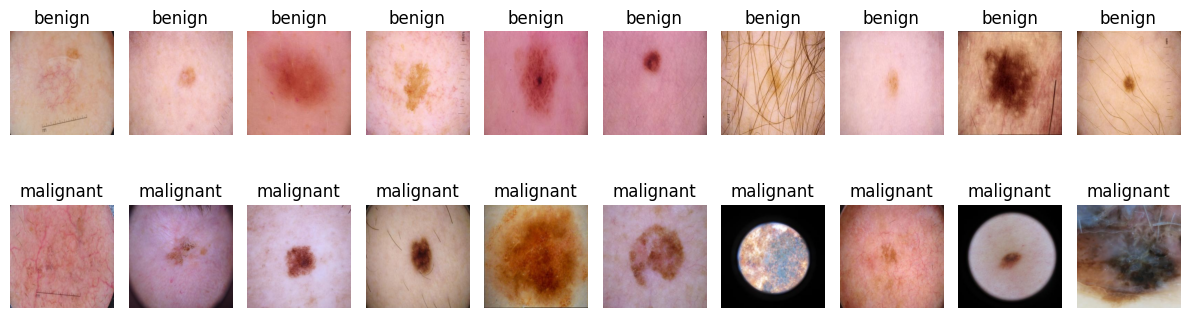

In [ ]:
images, labels = load_image(size = (299,299))
plot_image(20, 2, 10, images)

Trong project này, chúng tôi quyết định không thực hiện xử lý dữ liệu để giữ cho project đơn giản, tập trung chủ yếu vào việc tinh chỉnh (fine-tune) mô hình. Tuy nhiên, chúng tôi cũng xác định một số phương án xử lý dữ liệu tiềm năng nếu mô hình không đạt kết quả mong đợi. Quan sát ban đầu cho thấy phần lớn dữ liệu hình tròn có xu hướng tập trung nhiều hơn vào phân loại 'malignant', dẫn đến các giải pháp sau:

1. Viết hàm phát hiện hình tròn và cắt chúng thành hình vuông, để cải thiện quá trình nhận dạng.
2. Chuyển đổi tất cả các hình ảnh thành hình tròn, nhằm tạo sự đồng nhất về hình dạng.

Cuối cùng chúng tôi split bộ dữ liệu ra làm 3 phần tương ứng train: 70%, test: 15%, val: 15%.

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)

# First split: 70% training, 30% temporary (test + validation)
x_train, x_temp, y_train, y_temp = train_test_split(images, integer_encoded_labels, test_size=0.3, random_state=42)

y_train = to_categorical(y_train)

# Second split: Split temporary data equally into test and validation
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

y_val = to_categorical(y_val)

# Clean up to free memory
del images, labels, x_temp, y_temp

Sau khi phân tích dữ liệu, chúng tôi rút ra những kết luận sau:

1. Bộ dữ liệu chỉ bao gồm hai lớp (class), điều này làm cho nó khá đơn giản và dễ quản lý.
2. Số lượng dữ liệu không quá lớn, nằm trong khoảng cỡ trung bình, phù hợp cho việc xử lý.

Dựa trên những đặc điểm này, tiêu chí để lựa chọn mô hình phù hợp là:

1. **Top-1 Accuracy cao**: Đây là một chỉ số đánh giá khả năng của mô hình trong việc dự đoán chính xác nhất là lớp nào trong số các lớp có sẵn. Với chỉ số này, mô hình được coi là đã dự đoán đúng nếu lớp mà nó chọn là lớp chính xác. Lấy ví dụ từ bộ dữ liệu ImageNet, nơi có hơn 1000 lớp: nếu mô hình dự đoán một hình ảnh là "mèo Persia" và thực tế hình ảnh đó thực sự là "mèo Persia", thì đó là một dự đoán chính xác và tăng điểm Top-1 Accuracy. Điều này khác với Top-5 Accuracy, nơi mà một dự đoán được coi là chính xác nếu lớp đúng nằm trong 5 lựa chọn hàng đầu của mô hình. Trong bộ dữ liệu với số lớp ít, như trong trường hợp của dự án này, việc cần độ chính xác gần như tuyệt đối làm cho Top-1 Accuracy trở thành tiêu chí quan trọng hơn, vì nó phản ánh khả năng phân loại chính xác của mô hình trong mọi trường hợp cụ thể.

2. **Mô hình không quá phức tạp hoặc nặng**: Điều này đảm bảo rằng việc huấn luyện mô hình sẽ không đòi hỏi quá nhiều tài nguyên tính toán, và mô hình có thể hoạt động hiệu quả ngay cả trên phần cứng có hạn chế. Một mô hình đơn giản nhưng hiệu quả sẽ phù hợp hơn với bộ dữ liệu có quy mô vừa phải, giúp tránh việc 'overfitting' (quá khớp) - một tình trạng mà mô hình quá phức tạp so với dữ liệu đang xử lý.

Từ 2 tiêu chí nói trên chúng tôi đã chọn ra 4 pretrained model sau:


1.   MobileNetV2
2.   EfficientNetB0
3.   EfficientNetV2S
4.   InceptionV3

Cả file keras được run chỉ 1 lần, tất cả kết quả so sánh các model đều sử dụng chung 1 data train test val vì không có load lại data.

## Training Phase

### **MobileNetV2**

MobileNetV2 là một mô hình nhẹ, được thiết kế đặc biệt cho việc sử dụng trên thiết bị di động, nơi mà nguồn lực tính toán thường bị hạn chế. Phiên bản V2 này là bản cải tiến của MobileNetV1, với mức Top-1 Accuracy đạt 71.3%, đáng chú ý với một mô hình nhẹ như vậy.

Theo tài liệu của mô hình, hình ảnh cần được chuyển tỷ lệ về khoảng từ -1 đến 1 nếu sử dụng pretrained. Để thực hiện điều này mà không cần phải chuyển đổi hình ảnh ngoài từ bên ngoài lúc load data (và tránh việc chuyển đổi dữ liệu từ int8 sang float32 hay float64, điều có thể gây tràn RAM), chúng tôi đã thêm một layer chuyển đổi tỷ lệ vào trong mô hình.

Khi sử dụng các pretrained models, chúng tôi luôn sử dụng weights từ ImageNet và "khóa" (lock) một nửa số lượng layer lại. Mục đích của việc này là để chỉ thực hiện transfer learning trên một nửa số layer còn lại và thêm các fully connected layers ở cuối. Việc "khóa" các layer giúp giữ nguyên cách học low level feature hoặc "general details" mà mô hình đã học từ ImageNet. Điều này bao gồm các đặc điểm như cạnh, góc, và màu sắc, là nền tảng cho việc nhận diện hình ảnh. Một nửa còn lại của mô hình, sau khi được "mở khóa", được tinh chỉnh (fine-tuned) để học high level feature đặc trưng cho bộ dữ liệu cụ thể mà chúng tôi đang làm việc.

Khi sử dụng pretrained model, chúng tôi quyết định áp dụng kỹ thuật dropout với tỷ lệ 20% cho các neuron trước khi chúng đi vào các lớp fully connected (FC). Mục đích của việc này là để ngăn chặn hiện tượng overfitting.

Một vấn đề khác mà chúng tôi chú trọng là tránh "dead neurons" trong quá trình huấn luyện. Dead neuron là tình trạng một neuron trong mạng neural không còn hoạt động hoặc đóng góp vào quá trình học, thường xảy ra khi sử dụng hàm kích hoạt ReLU (Rectified Linear Unit). Điều này xảy ra khi các giá trị đầu vào của neuron là âm, khiến ReLU trả về giá trị 0 và neuron không được cập nhật trong quá trình lan truyền ngược (backpropagation).

Để giải quyết vấn đề này, chúng tôi sử dụng PReLU (Parametric ReLU) là một biến thể của ReLU. Điểm khác biệt của PReLU so với ReLU thông thường là nó cho phép một lượng nhỏ gradient "rò rỉ" qua khi giá trị đầu vào là âm. Điều này giúp các neuron vẫn có thể cập nhật và học hỏi dù có giá trị đầu vào âm, giảm thiểu khả năng xảy ra hiện tượng dead neuron và cải thiện quá trình huấn luyện của mô hình.

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, Input, Dropout, Flatten, Lambda, Conv2D, PReLU
from keras.models import Model

pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

num_layers = int(len(pretrained_model.layers) * 1 / 2)

for layer in pretrained_model.layers[:num_layers]:
    layer.trainable = False

input_layer = Input(shape=(224, 224, 3))
x = Lambda(lambda x: x / 127.5 - 1)(input_layer)
x = pretrained_model(x)

x = Dropout(0.2)(x)
x = Conv2D(640, (3, 3))(x)
x = PReLU()(x)
x = Conv2D(320, (3, 3))(x)
x = PReLU()(x)
x = Conv2D(80, (1, 1))(x)
x = PReLU()(x)
x = Flatten()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.load_weights("best_model_mobilenetv2.h5")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 5, 5, 640)         7373440   
                                                                 
 p_re_lu_18 (PReLU)          (None, 5, 5, 640)         16000     
                                                           

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor= 'accuracy',
    patience= 5,
    mode= 'max'
)

model_checkpoint = ModelCheckpoint(
    'best_model_mobilenetv2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
model.fit(x_train, y_train,
          epochs=100,
          verbose=1,
          validation_data = (x_val, y_val),
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
232/232 [==============================] - 52s 117ms/step - loss: 0.4711 - accuracy: 0.8735 - val_loss: 7.0466 - val_accuracy: 0.5223
Epoch 2/100
232/232 [==============================] - 24s 102ms/step - loss: 0.2084 - accuracy: 0.9192 - val_loss: 4.5336 - val_accuracy: 0.5280
Epoch 3/100
232/232 [==============================] - 24s 103ms/step - loss: 0.1824 - accuracy: 0.9321 - val_loss: 1.4496 - val_accuracy: 0.8146
Epoch 4/100
232/232 [==============================] - 24s 103ms/step - loss: 0.1731 - accuracy: 0.9353 - val_loss: 0.8844 - val_accuracy: 0.8397
Epoch 5/100
232/232 [==============================] - 24s 102ms/step - loss: 0.2045 - accuracy: 0.9277 - val_loss: 0.5583 - val_accuracy: 0.8837
Epoch 6/100
232/232 [==============================] - 24s 105ms/step - loss: 0.1461 - accuracy: 0.9460 - val_loss: 0.4769 - val_accuracy: 0.8931
Epoch 7/100
232/232 [==============================] - 23s 101ms/step - loss: 0.1394 - accuracy: 0.9488 - val_loss: 0.4113 -

In [ ]:
model.save("Model_mobilenetv2.h5")

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score

predictions = np.argmax(model.predict(x_test), axis = 1)

f1 = f1_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
accuracy = accuracy_score(y_test, predictions)

print("F1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)

50/50 [==============================] - 3s 40ms/step
F1 Score: 0.9259259259259259
Recall: 0.9246575342465754
Accuracy: 0.9321181646763043


Trong quá trình huấn luyện các mô hình, chúng tôi có chiến lược cho phép mô hình overfit, nhưng chúng tôi chỉ lưu lại "best model" thông qua cơ chế ModelCheckpoint. Điều này có nghĩa là, dù mô hình có thể đã học quá mức từ tập dữ liệu huấn luyện (overfitting), chúng tôi vẫn chỉ giữ lại phiên bản mô hình có hiệu suất tốt nhất trên tập dữ liệu kiểm thử (validation set).

Một quan sát đáng chú ý trong quá trình huấn luyện MobileNet là do cấu trúc đơn giản của mô hình, những thay đổi nhỏ trong cập nhật gradient của một vài neuron có thể gây ra sự thay đổi đáng kể trong kết quả đầu ra. Điều này thể hiện rõ ràng qua sự biến động của chỉ số độ chính xác trên tập kiểm thử (val_acc) so với tập huấn luyện (acc). Có những giai đoạn, chỉ số độ chính xác trên tập kiểm thử đã biến động mạnh, phản ánh rõ nét ảnh hưởng của việc cập nhật gradient đến tổng thể hiệu suất của mô hình. Điều này cũng là một dấu hiệu của sự không ổn định trong quá trình học của mô hình, và nó cần được quan sát và điều chỉnh cẩn thận trong quá trình tinh chỉnh mô hình.

Và cuối cùng khi test lại với tập test thì kết quả accuracy khá ổn và cao lên đến 93.21%. Đây là một mức chấp nhận được đối với chúng tôi.

**So sánh trực tiếp với model MobileNetV2 bên Pytorch:**

Có một điểm đặc biệt là tuy cùng một model với nhau nhưng kết quả model của Keras cao hơn (0.9321 so với 0.9233) điều này xuất phát từ việc theo paper data phải được scale về khoảng (-1;1) nhưng ở Pytorch tất cả data đều dc scale về (0;1).


### **EfficientNetB0**

Khác với MobileNet, EfficientNet, một mô hình học sâu hiện đại, được tạo ra với mục tiêu tối ưu hóa cả hiệu suất và hiệu quả tính toán. Điểm nổi bật của EfficientNet nằm ở cách tiếp cận cân đối trong việc mở rộng ba yếu tố chính của mô hình: độ sâu (số lớp), chiều rộng (số kênh), và độ phân giải. Sự cân nhắc này giúp mô hình vừa cải thiện khả năng học từ dữ liệu, vừa duy trì hiệu quả tính toán, đặc biệt so với các mô hình trước đó như MobileNet.

Trong các phiên bản của EfficientNet, phiên bản cơ bản là EfficientNet-B0, đáng chú ý với Top-1 Accuracy khoảng 77.1%. Đây là một kết quả ấn tượng cho một mô hình nhỏ gọn. Cấu trúc của EfficientNet-B0 minh họa rõ ràng cho cách tiếp cận độc đáo của EfficientNet trong việc cân nhắc mở rộng mô hình một cách có tỷ lệ, điều này làm nó trở thành một trong những mô hình hàng đầu trong lĩnh vực học sâu.

Sự cân nhắc trong việc mở rộng này không chỉ giúp EfficientNet hiệu quả về mặt tính toán mà còn giúp nó trở nên linh hoạt, có thể được điều chỉnh dễ dàng để phù hợp với nhiều loại nhiệm vụ và yêu cầu khác nhau, từ các thiết bị di động với nguồn lực hạn chế đến các hệ thống server mạnh mẽ.

Và họ các model nhà EfficientNet đều có 1 lớp layer scaling sẵn nên chúng ta không còn cần layer scaling nữa. Các phần còn lại của FC layers đều có mục đích giống với của MobileNet

In [ ]:
from keras.applications import EfficientNetB0
from keras.layers import Dense, Input, Dropout, Flatten, Lambda, Conv2D, PReLU
from keras.models import Model

pretrained_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

num_layers = int(len(pretrained_model.layers) * 1 / 2)

for layer in pretrained_model.layers[:num_layers]:
    layer.trainable = False

input_layer = Input(shape=(224, 224, 3))
x = pretrained_model(input_layer)

x = Dropout(0.2)(x)
x = Conv2D(640, (3, 3))(x)
x = PReLU()(x)
x = Conv2D(320, (3, 3))(x)
x = PReLU()(x)
x = Conv2D(80, (1, 1))(x)
x = PReLU()(x)
x = Flatten()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.load_weights("best_model_efficientnet.h5")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 640)         7373440   
                                                                 
 p_re_lu_15 (PReLU)          (None, 5, 5, 640)         16000     
                                                                 
 conv2d_16 (Conv2D)          (None, 3, 3, 320)         1843520   
                                                           

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor= 'accuracy',
    patience= 5,
    mode= 'max'
)

model_checkpoint = ModelCheckpoint(
    'best_model_efficientnet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
model.fit(x_train, y_train,
          epochs=100,
          verbose=1,
          validation_data = (x_val, y_val),
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
232/232 [==============================] - 63s 171ms/step - loss: 0.3039 - accuracy: 0.8971 - val_loss: 0.1963 - val_accuracy: 0.9296
Epoch 2/100
232/232 [==============================] - 36s 157ms/step - loss: 0.1686 - accuracy: 0.9379 - val_loss: 0.1986 - val_accuracy: 0.9340
Epoch 3/100
232/232 [==============================] - 34s 145ms/step - loss: 0.1406 - accuracy: 0.9462 - val_loss: 0.3569 - val_accuracy: 0.8674
Epoch 4/100
232/232 [==============================] - 36s 154ms/step - loss: 0.1359 - accuracy: 0.9522 - val_loss: 0.2004 - val_accuracy: 0.9283
Epoch 5/100
232/232 [==============================] - 36s 154ms/step - loss: 0.1012 - accuracy: 0.9648 - val_loss: 0.2451 - val_accuracy: 0.9151
Epoch 6/100
232/232 [==============================] - 36s 154ms/step - loss: 0.0845 - accuracy: 0.9675 - val_loss: 0.2287 - val_accuracy: 0.9271
Epoch 7/100
232/232 [==============================] - 34s 145ms/step - loss: 0.0658 - accuracy: 0.9767 - val_loss: 0.2338 -

In [ ]:
model.save("Model_efficientnet.h5")

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score

predictions = np.argmax(model.predict(x_test), axis = 1)

f1 = f1_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
accuracy = accuracy_score(y_test, predictions)

print("F1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)

50/50 [==============================] - 5s 59ms/step
F1 Score: 0.9319298245614035
Recall: 0.9095890410958904
Accuracy: 0.9390320553111251


Ở đây, sự ảnh hưởng quan trọng của kiến trúc mô hình EfficientNet đến khả năng học của nó được thể hiện rõ ràng. Khi so sánh trực tiếp với MobileNet, chúng ta có thể thấy rằng EfficientNet có lượng tham số và kích thước mô hình lớn hơn một chút so với MobileNet. Tuy nhiên, điểm nổi bật của EfficientNet là khả năng học ổn định mà nó mang lại. Điều này được phản ánh qua việc không có sự chênh lệch lớn giữa chỉ số độ chính xác trên tập kiểm thử (val_acc) và tập huấn luyện (acc).

Điểm đáng chú ý khác của EfficientNet là độ chính xác cao đến 93,903%. Con số này, với các chữ số thập phân phía sau, không chỉ thể hiện hiệu suất ấn tượng của mô hình mà còn là một chi tiết quan trọng, sẽ được giải thích thêm trong phần giới thiệu về mô hình V2S tiếp theo.

### **EfficientNetV2S**

EfficientNetV2S là một biến thể tiên tiến của dòng EfficientNet, tiếp tục kế thừa và mở rộng các đặc điểm nổi bật của phiên bản B0. Mô hình này được thiết kế để đạt được hiệu suất cao với hiệu quả tính toán tối ưu, thích hợp cho nhiều ứng dụng từ thiết bị di động đến hệ thống server mạnh mẽ.

In [ ]:
from keras.applications import EfficientNetV2S
from keras.layers import Dense, Input, Dropout, Flatten, Lambda, Conv2D, PReLU
from keras.models import Model

pretrained_model = EfficientNetV2S(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

num_layers = int(len(pretrained_model.layers) * 1 / 2)

for layer in pretrained_model.layers[:num_layers]:
    layer.trainable = False

input_layer = Input(shape=(224, 224, 3))
x = pretrained_model(input_layer)

x = Dropout(0.2)(x)
x = Conv2D(640, (3, 3))(x)
x = PReLU()(x)
x = Conv2D(320, (3, 3))(x)
x = PReLU()(x)
x = Conv2D(80, (1, 1))(x)
x = PReLU()(x)
x = Flatten()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.load_weights("Model_efficientnetv2s.h5")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 5, 5, 640)         7373440   
                                                                 
 p_re_lu_24 (PReLU)          (None, 5, 5, 640)         16000     
                                                                 
 conv2d_25 (Conv2D)          (None, 3, 3, 320)         1843520   
                                                           

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor= 'accuracy',
    patience= 5,
    mode= 'max'
)

model_checkpoint = ModelCheckpoint(
    'best_model_efficientnetv2s.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
model.fit(x_train, y_train,
          epochs=100,
          verbose=1,
          validation_data = (x_val, y_val),
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
232/232 [==============================] - 126s 346ms/step - loss: 0.3123 - accuracy: 0.8868 - val_loss: 0.1929 - val_accuracy: 0.9353
Epoch 2/100
232/232 [==============================] - 73s 314ms/step - loss: 0.2008 - accuracy: 0.9258 - val_loss: 0.1843 - val_accuracy: 0.9428
Epoch 3/100
232/232 [==============================] - 67s 289ms/step - loss: 0.1593 - accuracy: 0.9402 - val_loss: 0.2011 - val_accuracy: 0.9290
Epoch 4/100
232/232 [==============================] - 67s 288ms/step - loss: 0.1123 - accuracy: 0.9564 - val_loss: 0.1949 - val_accuracy: 0.9277
Epoch 5/100
232/232 [==============================] - 71s 306ms/step - loss: 0.0944 - accuracy: 0.9651 - val_loss: 0.1982 - val_accuracy: 0.9309
Epoch 6/100
232/232 [==============================] - 71s 307ms/step - loss: 0.0728 - accuracy: 0.9736 - val_loss: 0.2260 - val_accuracy: 0.9346
Epoch 7/100
232/232 [==============================] - 71s 306ms/step - loss: 0.0612 - accuracy: 0.9767 - val_loss: 0.2226 

In [ ]:
model.save("Model_efficientnetv2s.h5")

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score

predictions = np.argmax(model.predict(x_test), axis = 1)

f1 = f1_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
accuracy = accuracy_score(y_test, predictions)

print("F1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)

50/50 [==============================] - 9s 114ms/step
F1 Score: 0.9336071184120466
Recall: 0.9342465753424658
Accuracy: 0.9390320553111251


Trong phần kết luận này, chúng tôi nhận thấy một điểm đặc biệt liên quan đến EfficientNetB0 và EfficientNetV2S: mức độ chính xác (accuracy) của cả hai mô hình này không chỉ tương đương nhau mà còn giống hệt nhau đến từng con số thập phân. Phát hiện này dẫn đến một kết luận quan trọng: khi hai mô hình thuộc cùng một dòng, như EfficientNetB0 và V2S, có thể có những cải tiến nhỏ giữa các phiên bản, nhưng mức độ chính xác giống hệt nhau ở mức độ chi tiết như vậy cho thấy cả hai mô hình có khả năng đã đạt đến cùng một "local minimum". Điều này có nghĩa là cả hai mô hình đều sử dụng một cơ chế hoặc phương trình tương tự nhau để đưa ra dự đoán, đạt được hiệu suất tối ưu trong việc nhận diện và phân loại dữ liệu. Sự giống nhau đến mức độ này không chỉ là một sự trùng hợp kỳ lạ mà còn phản ánh sự chính xác và ổn định của kiến trúc EfficientNet trong việc đạt được kết quả tối ưu.

Các kết luận còn lại về val_acc và acc đều tương tự với EfficientNetB0

### **InceptionV3**

InceptionV3 là một mô hình học sâu nổi bật trong lĩnh vực thị giác máy tính, thuộc dòng mô hình Inception được phát triển bởi Google. Mô hình này được thiết kế để cung cấp một cấu trúc hiệu quả về mặt tính toán mà vẫn duy trì độ chính xác cao trong các tác vụ nhận diện hình ảnh. Điểm đặc biệt của InceptionV3 là sự sử dụng của các "mô-đun inception", các khối xây dựng chính của mô hình, cho phép nó xử lý thông tin ở nhiều kích cỡ khác nhau thông qua các bộ lọc có kích thước đa dạng trong cùng một lớp mạng.

InceptionV3 đã đạt được những kết quả ấn tượng trong các cuộc thi và bài toán nhận diện hình ảnh, đồng thời được sử dụng rộng rãi trong cộng đồng nghiên cứu và ứng dụng thực tế. Mô hình này còn được biết đến với khả năng huấn luyện nhanh chóng và hiệu quả về mặt tài nguyên tính toán, làm cho nó trở thành một lựa chọn phổ biến trong các ứng dụng liên quan đến thị giác máy tính.

Ngoài ra, InceptionV3 còn nổi bật với cách tiếp cận độc đáo trong việc giảm số lượng tham số mà không làm giảm hiệu suất của mô hình, giúp giảm nguy cơ overfitting và tăng khả năng tổng quát hóa trên dữ liệu mới. Sự cân nhắc kỹ lưỡng trong thiết kế và tối ưu hóa cấu trúc mô hình làm cho InceptionV3 không chỉ mạnh mẽ về mặt kỹ thuật mà còn dễ tiếp cận và ứng dụng trong nhiều loại dự án khác nhau.

Khác với các model trên, InceptionV3 sử dụng image size lên tới 299 và có yêu cầu scaling về -1 tới 1 nên chúng tôi đã điều chỉnh lại size và thêm lớp scaling vào.

In [ ]:
from keras.applications import InceptionV3
from keras.layers import Dense, Input, Dropout, Flatten, Lambda, Conv2D, PReLU
from keras.models import Model

pretrained_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')

num_layers = int(len(pretrained_model.layers) * 3 / 4)

for layer in pretrained_model.layers[:num_layers]:
    layer.trainable = False

input_layer = Input(shape=(299, 299, 3))
x = Lambda(lambda x: x / 127.5 - 1)(input_layer)
x = pretrained_model(x)

x = Dropout(0.2)(x)
x = Conv2D(640, (3, 3))(x)
x = PReLU()(x)
x = Conv2D(320, (3, 3))(x)
x = PReLU()(x)
x = Conv2D(80, (1, 1))(x)
x = PReLU()(x)
x = Flatten()(x)
x = Dense(640)(x)
x = PReLU()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.load_weights("best_model_inception.h5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 conv2d_191 (Conv2D)         (None, 6, 6, 640)         11797120  
                                                                 
 p_re_lu_4 (PReLU)           (None, 6, 6, 640)         23040     
                                                                 
 conv2d_192 (Conv2D)         (None, 4, 4, 320)         1843

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor= 'accuracy',
    patience= 5,
    mode= 'max'
)

model_checkpoint = ModelCheckpoint(
    'best_model_inception.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
model.fit(x_train, y_train,
          epochs=100,
          verbose=1,
          validation_data = (x_val, y_val),
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
232/232 [==============================] - 108s 358ms/step - loss: 0.5339 - accuracy: 0.8695 - val_loss: 0.2578 - val_accuracy: 0.9170
Epoch 2/100
232/232 [==============================] - 66s 284ms/step - loss: 0.1980 - accuracy: 0.9242 - val_loss: 0.2307 - val_accuracy: 0.9221
Epoch 3/100
232/232 [==============================] - 66s 283ms/step - loss: 0.1563 - accuracy: 0.9390 - val_loss: 0.1907 - val_accuracy: 0.9365
Epoch 4/100
232/232 [==============================] - 56s 239ms/step - loss: 0.1347 - accuracy: 0.9453 - val_loss: 0.2373 - val_accuracy: 0.9202
Epoch 5/100
232/232 [==============================] - 65s 281ms/step - loss: 0.1223 - accuracy: 0.9542 - val_loss: 0.1740 - val_accuracy: 0.9384
Epoch 6/100
232/232 [==============================] - 56s 239ms/step - loss: 0.0951 - accuracy: 0.9640 - val_loss: 0.2694 - val_accuracy: 0.9334
Epoch 7/100
232/232 [==============================] - 59s 256ms/step - loss: 0.0972 - accuracy: 0.9623 - val_loss: 0.3116 

In [ ]:
model.save("Model_inception.h5")

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score

predictions = np.argmax(model.predict(x_test), axis = 1)

f1 = f1_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
accuracy = accuracy_score(y_test, predictions)

print("F1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)

50/50 [==============================] - 8s 115ms/step
F1 Score: 0.9293628808864267
Recall: 0.9191780821917809
Accuracy: 0.9358893777498428


Như đã nêu trước đây, chúng tôi ban đầu đã bỏ quên việc thêm lớp scaling vào mô hình, điều này dẫn đến kết quả huấn luyện không ổn định. Cụ thể, chỉ số độ chính xác trên tập kiểm thử (val_acc) đã giảm xuống mức 0.5 và liên tục cho ra các kết quả gần với 0.5 và nhảy lên lại 0.8-0.9, thể hiện sự hỗn loạn trong việc học của mô hình. Điều này chứng tỏ rằng, việc điều chỉnh tỷ lệ của dữ liệu (scaling) để phù hợp với giá trị yêu cầu của pretrained weights là rất quan trọng.

Khi thêm lớp scaling, kết quả huấn luyện của mô hình đã trở nên ổn định hơn, chỉ có một vài trường hợp mà chỉ số val_acc giảm sâu. Một lý do có thể giải thích cho sự giảm sút này là do tập val có thể chứa một số mẫu dữ liệu outliers hoặc các trường hợp đặc biệt mà mô hình chưa gặp trong quá trình huấn luyện. Điều này dẫn đến việc mô hình chưa thể tổng quát hóa tốt trên tất cả các trường hợp. Ngoài ra, việc giảm sâu có thể cũng do một số bước điều chỉnh hyperparameters chưa hoàn toàn phù hợp, hoặc cần có thêm quá trình fine-tuning thêm nữa để cải thiện khả năng dự đoán của mô hình trên dữ liệu val.